## Deutsch’s Algorithm

We have a function which takes in a bit and outputs a bit. This can be represented as \( f: \{0, 1\} \rightarrow \{0, 1\} \).

The function \( f \) has a property; either it is constant or balanced.

- If constant, the outputs are the same regardless of the inputs, i.e., \( f(0) = f(1) \).
- If balanced, the outputs are balanced across their possibilities, i.e., if \( f(0) = 0 \) then \( f(1) = 1 \) or if \( f(0) = 1 \) then \( f(1) = 0 \).

The question we would like to answer is if the function is constant or balanced.

Classically, if we are given a function \( f \), we can solve to find its property via the code below:

In [1]:
# Treat the code snippet below like a black box, i.e., you don't have access to the value of the property argument and can just query f with different inputs.


def f(x, property='constant'):

    if property == 'constant':

        # The output is a 1 regardless of the input; we can also make the output to be 0.

        if x == 0:
            return 1
        elif x == 1:
            return 1

    if property == 'balanced':

        # The output depends on the input.

        if x == 0:
            return 1
        elif x == 1:
            return 0

Let us now classically find out if the function we defined above is constant or balanced.

In [2]:
if f(0) == 0:
    if f(1) == 0:
        print('The function is constant')
    elif f(1) == 1:
        print('The function is balanced')

elif f(0) == 1:
    if f(1) == 1:
        print('The function is constant')
    elif f(1) == 0:
        print('The function is balanced')

The function is constant


If you step through the `if` statements above, you will see that we require two calls to the function to determine its property. That is, we have to query twice.

The claim is that Deutsch’s algorithm can solve for this property with one function evaluation, demonstrating quantum advantage.

Below, we first go through the math and then the implementation in CUDA Quantum.

# XOR Operation

The XOR (exclusive OR) operation follows the rules of addition modulo 2. For example, a quick way to perform the XOR calculation is if the result of the addition is an even number, the result is 0; otherwise, it is 1.

# Quantum Oracles

Suppose we have a function \( f \). We can compute this function on a quantum computer using oracles, which we treat as black box functions that yield the output with an appropriate sequence of logic gates.

An oracle represented as \( U_f \) allows us to transform the state \( |x\rangle|y\rangle \) into \( |x\rangle|y \oplus f(x)\rangle \). If \( y = 0 \), then \( |x\rangle|0 \oplus f(x)\rangle = |x\rangle|f(x)\rangle \).

This is remarkable because by setting \( y = 0 \), we can extract the value of \( f(x) \) by measuring the value of the second qubit.

# Phase Oracle

Since \( f(x) \) can be either 0 or 1, we have that \( f(x) = 0 \) or \( f(x) = 1 \).

Similarly, \( f(\bar{x}) = 0 \) or \( f(\bar{x}) = 1 \), where the bar on top of \( x \) denotes ‘not \( x \)’.

Let us now prove a result which we shall use later:

\[ U_f|x\rangle|-\rangle = (-1)^{f(x)}|x\rangle|-\rangle \]

In summary, \( U_f \) applies a phase to \( |-\rangle \) based on the value of \( f(x) \), leaving the \( x \) qubit unchanged.

# Quantum Parallelism

Consider:

\[ U_f \left( \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle) \right)|-\rangle = \frac{1}{\sqrt{2}} \left( |0\rangle(-1)^{f(0)} + |1\rangle(-1)^{f(1)} \right)|-\rangle \]

We have calculated information about both \( f(0) \) and \( f(1) \) simultaneously. Quantum mechanics allows for parallelism by exploiting the ability of superposition states.

# Deutsch's Algorithm

Our aim is to find out if \( f \) is a constant or a balanced function. If constant, \( f(0) = f(1) \), and if balanced, \( f(0) \neq f(1) \).

We step through the circuit diagram below and follow the math after the application of each gate.


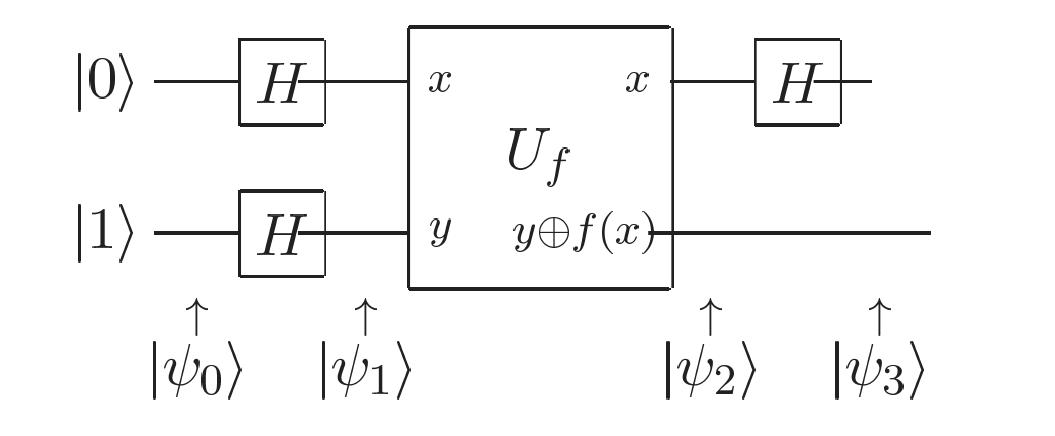

Using the result we proved in the phase oracle section above:

We now drop the second qubit in the \( |-\rangle \) state from our derivations as the figure above has no further gate operations acting on it. Remember, our aim is to determine if \( f \) is a constant or a balanced function. We have the following options:

We can now measure the first qubit to yield either a \( |0\rangle \) or a \( |1\rangle \) to determine if \( f \) is constant or balanced.

Deutsch’s algorithm may not be practically useful but it does demonstrate quantum advantage since it uses one function call to determine the property of \( f \) in comparison to two for classical methods.

In [3]:
# Import the CUDA-Q package and set the target to run on NVIDIA GPUs.

import cudaq
import numpy as np

from typing import List

cudaq.set_target("nvidia")

In [4]:
# Here we input the values of [f(0), f(1)] which allows us to represent constant or balanced functions.

fx = [0, 1]

In [5]:
# Let us now code up the circuit shown above following the state Psi after each step.

qubit_count = 2


@cudaq.kernel
def kernel(fx: List[int]):
    qubit_0 = cudaq.qubit()
    qubit_1 = cudaq.qubit()

    # Psi 0
    x(qubit_1)

    # Psi 1
    h(qubit_0)
    h(qubit_1)

    # Psi 2 - oracle
    if fx[0] == 1:
        x.ctrl(qubit_0, qubit_1)
        x(qubit_1)

    if fx[1] == 1:
        x.ctrl(qubit_0, qubit_1)

    # Psi 3
    h(qubit_0)

    # Measure the qubit to yield if the function is constant or balanced.
    mz(qubit_0)


print(cudaq.draw(kernel, fx))

result = cudaq.sample(kernel, fx, shots_count=1)

if np.array(result)[0] == '0':
    print('f(x) is a constant function')
elif np.array(result)[0] == '1':
    print('f(x) is a balanced function')

     ╭───╮          ╭───╮
q0 : ┤ h ├───────●──┤ h ├
     ├───┤╭───╮╭─┴─╮╰───╯
q1 : ┤ x ├┤ h ├┤ x ├─────
     ╰───╯╰───╯╰───╯     

f(x) is a balanced function
